<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/toxic_comment_classification/Improved%20Toxic%20Comment%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Comment Classification

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

[Kaggle challenge link](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/)

### Download the dataset from kaggle

In [10]:
!pip install kaggle

In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"3ebe1017281784a1ca4b048c597b0c87"}'}

In [12]:
!mkdir ~/.kaggle

In [13]:
!cp kaggle.json ~/.kaggle

In [14]:
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 47.1MB/s]
 34% 9.00M/26.3M [00:01<00:03, 5.43MB/s]
100% 26.3M/26.3M [00:01<00:00, 17.6MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 48.4MB/s]
 90% 21.0M/23.4M [00:01<00:00, 5.00MB/s]
100% 23.4M/23.4M [00:01<00:00, 15.2MB/s]


In [16]:
!ls

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip
sample_data  test.csv.zip		train.csv.zip


In [17]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


### Required Installations

In [18]:
!pip install youtokentome

### Imports

In [19]:
import re
import time
import math
import random
import codecs
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext import data

import youtokentome

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Exploration

In [22]:
df = pd.read_csv('train.csv')

In [23]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [24]:
len(df)

159571

#### Category Analysis

In [ ]:
# dropping id and comment text
df_toxic = df.drop(['id', 'comment_text'], axis=1)
# calculating total count of each category comments
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])
df_stats

,category,count
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


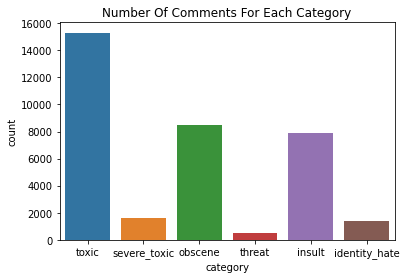

In [ ]:
sns.barplot(x='category', y='count', data=df_stats)
plt.title("Number Of Comments For Each Category")
plt.show()

This shows that the number of comments in each category is extremely unbalanced.

Let's check whether each comment has been tagged or not?

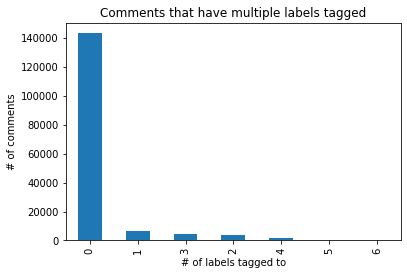

89.83211235124176 % comments have no labels associated to them.


In [ ]:
rowsums = df_toxic.iloc[:,:].sum(axis=1)
valcount = rowsums.value_counts()
valcount.plot.bar()
plt.xlabel("# of labels tagged to")
plt.ylabel("# of comments")
plt.title("Comments that have multiple labels tagged")
plt.show()

print(valcount[0]*100/sum(valcount),"% comments have no labels associated to them.")

This essentially shows that a large amount of the entire dataset is tagged to none of the six categories.

Correlation between categories

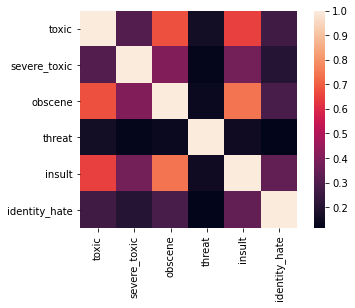

In [ ]:
sns.heatmap(df.corr(), square=True)
plt.show()

#### Comment Analysis

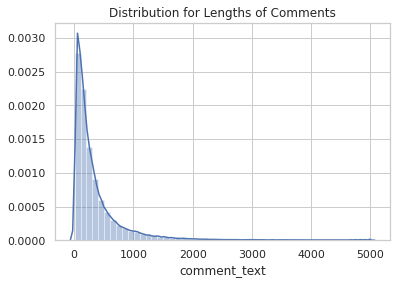

In [ ]:
lens = df.comment_text.str.len()
sns.set(style="whitegrid")
sns.distplot(lens)
plt.title("Distribution for Lengths of Comments")
plt.show()

In [ ]:
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

In [ ]:
print("Number of Null Comments : ", df['comment_text'].isnull().sum())

Number of Null Comments :  0


### Data Processing

In [25]:
def preprocess(text):
    # -- Converting to lower case
    text = text.lower()
    
    # replacing english abbreviations with full forms
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    # text = re.sub('\W', ' ', text)
    # text = re.sub('\s+', ' ', text)

    text = " ".join(text.split()).strip()
    return text

In [26]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [27]:
preprocess(df['comment_text'][0])

'explanation why the edits made under my username hardcore metallica fan were reverted? they were not vandalisms, just closure on some gas after i voted at new york dolls fac. and please do not remove the template from the talk page since i am retired now.89.205.38.27'

In [28]:
df['processed_comment_text'] = df['comment_text'].apply(lambda txt : preprocess(txt))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i am ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i am really not trying to edit war. i..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" more i can not make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


In [29]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

In [30]:
len(train_df), len(val_df), len(test_df)

(127656, 15957, 15958)

In [31]:
def create_class_weight(labels_dict):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    num_classes = len(labels_dict)

    for key in keys:
        score = round(total / (num_classes * labels_dict[key]), 2)
        class_weight[key] = score
    
    return class_weight


In [32]:
train_df_toxic = train_df.drop(['id', 'processed_comment_text', 'comment_text'], axis=1)
# calculating total count of each category comments
counts = {}
categories = list(train_df_toxic.columns.values)
for ind, i in enumerate(categories):
    counts[ind] = train_df_toxic[i].sum()

print(counts)
weights = create_class_weight(counts)
weights

{0: 12238, 1: 1274, 2: 6734, 3: 404, 4: 6263, 5: 1111}


{0: 0.38, 1: 3.67, 2: 0.69, 3: 11.56, 4: 0.75, 5: 4.2}

In [33]:
columns = ['processed_comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df = train_df[columns]
val_df = val_df[columns]
test_df = test_df[columns]

In [34]:
train_df.to_csv('train_split.csv', columns=columns)
val_df.to_csv('val_split.csv', columns=columns)
test_df.to_csv('test_split.csv', columns=columns)

In [35]:
# using only training data to train the BPE tokenizer
all_data = list(train_df['processed_comment_text'].values)

with codecs.open("train_comments_data.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(all_data))

In [36]:
# free some ram
del all_data

### BPE tokenization

In [37]:
# Perform BPE
print("\nLearning BPE...")
youtokentome.BPE.train(data="train_comments_data.txt", vocab_size=15000, model="bpe.model")


Learning BPE...


In [38]:
# Load BPE model
print("\nLoading BPE model...")
bpe_model = youtokentome.BPE(model="bpe.model")


Loading BPE model...


In [39]:
# Special Tokens
print(f"<BOS>: {bpe_model.subword_to_id('<BOS>')}")    # Begining of the sentence token
print(f"<EOS>: {bpe_model.subword_to_id('<EOS>')}")    # End of the sentence token
print(f"<UNK>: {bpe_model.subword_to_id('<UNK>')}")    # Unknown token
print(f"<PAD>: {bpe_model.subword_to_id('<PAD>')}")    # Pad token

<BOS>: 2
<EOS>: 3
<UNK>: 1
<PAD>: 0


In [40]:
pad_index = bpe_model.subword_to_id('<PAD>')

In [41]:
sentence = "This is a sample sentence"
encoded_ids = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.ID)
encoded_text = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.SUBWORD)
decoded_text = bpe_model.decode(encoded_ids, ignore_ids=[2, 3])

print(encoded_ids)
print(encoded_text)
print(decoded_text)

[2007, 1975, 1929, 12467, 3424]
['▁this', '▁is', '▁a', '▁sample', '▁sentence']
['this is a sample sentence']


In [42]:
# define a tokenizer method which takes in a sentence and returns ids
# by defining this, we can configure the tokenizer to torchtext Field
def bpe_tokenizer(sentence):
    encoded_ids = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.ID)
    return encoded_ids

In [43]:
bpe_tokenizer("This is a sample sentence")

[2007, 1975, 1929, 12467, 3424]

### Fields

In [44]:
tokenizer = data.get_tokenizer(bpe_tokenizer)
TEXT = data.Field(tokenize=tokenizer, use_vocab=False, pad_token=pad_index, include_lengths=True)

In [45]:
LABEL = data.LabelField(use_vocab=False, dtype=torch.float32)
fields = [(None, None), ("comment", TEXT), ("toxic", LABEL), ("severe_toxic", LABEL), ("obscene", LABEL), ("threat", LABEL), ("insult", LABEL), ("identity_hate", LABEL)]

### Datasets

In [46]:
train_dataset, valid_dataset, test_dataset = data.TabularDataset.splits(path='.',
                                                train='train_split.csv', validation='val_split.csv', test="test_split.csv",
                                                format='csv', skip_header=True, fields=fields)

In [47]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 127656
Number of validation examples: 15957
Number of testing examples: 15958


In [48]:
print(vars(train_dataset.examples[1]))

{'comment': [2646, 3091, 2244, 4590, 2694, 1981, 2126, 1976, 3224, 9708, 2059, 1962, 2299, 1958, 5714, 1958, 2318, 1929, 4478, 1967, 1936, 4080, 12158, 13772, 2315, 28, 1971, 2292, 2122, 2126, 1976, 2138, 8776, 1958, 8092, 3185, 1962, 2360, 1929, 3526, 2841, 4824, 1968, 7792, 3554, 2151, 3033, 2235, 1978, 2018, 1929, 2355, 3541, 37, 2045, 1978, 1971, 1931, 2126, 2292, 2835, 1936, 4469, 3140, 1998, 11159, 13534, 8, 2327, 18, 3215, 2254, 1958, 2067, 2540, 3978, 2411, 1998, 7443, 30, 4413, 11834, 2073, 2163, 3418, 1962, 2018, 1958, 1976, 2207, 5701, 1966, 6090, 3327, 1982, 2966, 2433, 2036, 2599, 1971, 1982, 4327, 1975, 2185, 3452, 1997, 25, 3421, 4338, 45], 'toxic': '0', 'severe_toxic': '0', 'obscene': '0', 'threat': '0', 'insult': '0', 'identity_hate': '0'}


In [49]:
print(f"Vocab size: {bpe_model.vocab_size()}")

Vocab size: 15000


### Iterators

In [50]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.comment),
    sort_within_batch=True,
    device=device
)

In [51]:
temp = next(iter(train_iterator))
print(temp.comment[0].shape, temp.comment[1].shape)
print(temp.toxic.shape)
print(temp.severe_toxic.shape)
print(temp.obscene.shape)
print(temp.threat.shape)
print(temp.insult.shape)
print(temp.identity_hate.shape)


torch.Size([199, 64]) torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])


### Model

In [134]:
class BiGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, n_layers, pad_idx, dropout):
        super().__init__()
        
        self.n_layers = n_layers
        self.hid_dim = hid_dim

        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.out = nn.Linear(hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_length):
        # src => [seq_len, batch_size]
        # src_length => [batch_size]

        embedded = self.dropout(self.embedding(src))
        # embedded => [seq_len, batch_size, emb_dim]

        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, src_length)
        packed_outputs, hidden = self.rnn(packed_input)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs => [seq_len, batch_size, hidden_dim * 2]
        # hidden => [num_layers * num_dir, batch_size, hidden_dim]
        
        combined_outputs = outputs[:, :, :self.hid_dim] + outputs[:, :, self.hid_dim:]
        # combined_outputs => [seq_len, batch_size, hidden_dim]
        
        max_pooled = torch.max(combined_outputs, dim=0)[0]
        # max_pooled => [batch_size, hidden_dim]
        
        mean_pooled = torch.mean(combined_outputs, dim=0)
        # mean_pooled => [batch_size, hidden_dim]

        combined = torch.cat((mean_pooled, max_pooled), dim=-1)
        # combined => [batch_size, hidden_dim * 2]

        logits = torch.sigmoid(self.out(self.dropout(combined)))
        # logits => [batch_size, output_dim]

        return logits

In [135]:
PAD_IDX = pad_index
INPUT_DIM = bpe_model.vocab_size()
EMB_DIM = 100
HID_DIM = 256
N_LAYERS = 2
OUTPUT_DIM = 6
DROPOUT = 0.4

model = BiGRU(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, PAD_IDX, DROPOUT).to(device)

In [136]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.uniform_(m.weight.data, -0.08, 0.08)

model.apply(init_weights)

BiGRU(
  (embedding): Embedding(15000, 100, padding_idx=0)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.4, bidirectional=True)
  (out): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [137]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,235,686 trainable parameters


### Optimizer & Loss Criterion

In [138]:
LEARNING_RATE = 0.001

class_weights = torch.tensor(list(weights.values()), dtype=torch.float).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.BCELoss(weight=class_weights)

### Accuracy

In [139]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

### Training Method

In [140]:
def train(model, iterator, criterion, optimizer, clip):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    for i, batch in enumerate(iterator):
        src, src_len = batch.comment
        trg = torch.cat((
            batch.toxic.unsqueeze(1),
            batch.severe_toxic.unsqueeze(1),
            batch.obscene.unsqueeze(1),
            batch.threat.unsqueeze(1),
            batch.insult.unsqueeze(1),
            batch.identity_hate.unsqueeze(1)),
            dim=1).to(device)
        labels = torch.max(trg, 1)[1]

        optimizer.zero_grad()
        predictions = model(src, src_len)
        # predictions => [batch_size, output_dim]
        # trg => [batch_size, outptu_dim]

        loss = criterion(predictions, trg)            
        acc = categorical_accuracy(predictions, labels)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


### Validation Method

In [141]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch.comment
            trg = torch.cat((
                batch.toxic.unsqueeze(1),
                batch.severe_toxic.unsqueeze(1),
                batch.obscene.unsqueeze(1),
                batch.threat.unsqueeze(1),
                batch.insult.unsqueeze(1),
                batch.identity_hate.unsqueeze(1)),
                dim=1).to(device)
            labels = torch.max(trg, 1)[1]

            predictions = model(src, src_len)
            # predictions => [batch_size, output_dim]
            # trg => [batch_size, outptu_dim]

            loss = criterion(predictions, trg)            
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [142]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

### Training

In [143]:
N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss, val_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tValid Loss: {valid_loss:.3f} | Val. Acc: {val_acc*100:.2f}%")

Epoch: 01 | Time: 3m 43.45808672904968s
	Train Loss: 0.103 | Train Acc: 89.09%
	Valid Loss: 0.071 | Val. Acc: 98.99%
Epoch: 02 | Time: 3m 42.811771631240845s
	Train Loss: 0.068 | Train Acc: 95.57%
	Valid Loss: 0.068 | Val. Acc: 99.29%
Epoch: 03 | Time: 3m 43.61421489715576s
	Train Loss: 0.058 | Train Acc: 95.70%
	Valid Loss: 0.068 | Val. Acc: 99.16%


### Evaluation

In [144]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.066 |  Test Acc: 99.51%


In [145]:
def get_roc_auc_score(iterator):
    model.eval()
    all_labels = []
    all_predictions = []
    all_scores = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch.comment
            trg = torch.cat((
                batch.toxic.unsqueeze(1),
                batch.severe_toxic.unsqueeze(1),
                batch.obscene.unsqueeze(1),
                batch.threat.unsqueeze(1),
                batch.insult.unsqueeze(1),
                batch.identity_hate.unsqueeze(1)),
                dim=1).to(device)

            logits = model(src, src_len)

            all_labels.append(trg)
            all_predictions.append(logits)

    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    return metrics.roc_auc_score(all_labels.detach().cpu().numpy(), all_predictions.detach().cpu().numpy())

In [146]:
get_roc_auc_score(train_iterator)

0.9913797416089226

In [147]:
get_roc_auc_score(valid_iterator)

0.9847866485059021

In [148]:
get_roc_auc_score(test_iterator)

0.9873363642265511

## Further Improvements

*   Pre-trained embeddings
*   Cross Validation
*   Ensemble of Networks
*   Data Augmentation

